In [1]:
import time
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import torch
from datasets import Dataset
from hydra import compose, initialize
from omegaconf import OmegaConf
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from src.seed import seed_everything
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
)

warnings.filterwarnings("ignore")
with initialize(config_path="config", version_base=None):
    cfg = compose(config_name="config")
    cfg.exp_number = Path().resolve().name

print(OmegaConf.to_yaml(cfg, resolve=True))

seed_everything(cfg.seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


lgb:
  params:
    objective: binary
    metric: auc
    verbose: -1
    boosting_type: gbdt
    learning_rate: 0.01
    max_depth: 5
    num_leaves: 31
    min_data_in_leaf: 50
    bagging_fraction: 0.8
    bagging_freq: 1
    feature_fraction: 0.8
    lambda_l1: 0
    lambda_l2: 1
    seed: 42
  early_stopping_rounds: 100
  log_evaluation: 100
  num_boost_round: 10000000
bert:
  params:
    model_path: microsoft/deberta-v3-large
    metric: auc
    target_col_class_num: 2
    max_length: 192
    fp16: true
    learning_rate: 2.0e-05
    epochs: 2
    per_device_train_batch_size: 8
    per_device_eval_batch_size: 32
    steps: 50
    lr_scheduler_type: linear
    weight_decay: 0.01
exp_number: '005'
run_name: base
data:
  data_root: ../../data
  results_root: ../../results
  train_path: ../../data/train.csv
  clothing_path: ../../data/clothing_master.csv
  test_path: ../../data/test.csv
  sample_submission_path: ../../data/sample_submission.csv
  results_dir: ../../results/005/base
se

In [ ]:

import numpy as np
import pandas as pd
import torch
from datasets import Dataset
from hydra import compose, initialize
from omegaconf import OmegaConf
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from src.seed import seed_everything
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
)

warnings.filterwarnings("ignore")
with initialize(config_path="config", version_base=None):
    cfg = compose(config_name="config")
    cfg.exp_number = Path().resolve().name

print(OmegaConf.to_yaml(cfg, resolve=True))

seed_everything(cfg.seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


### Import

In [3]:
debug = False

train_df = pd.read_csv(cfg.data.train_path)
clothing_df = pd.read_csv(cfg.data.clothing_path)
test_df = pd.read_csv(cfg.data.test_path)

if debug:
    train_df = train_df.sample(500)

def preprocess(df):
    # df["prompt"] = "I am " + df["Age"].map(str) + " years old" + " [SEP] " + "this review has " + df["Positive Feedback Count"].map(str)+ " positive feedback by user" + " [SEP] " + "TITLE: " + df["Title"].fillna("none") + " [SEP] " + "REVIEW: " + df["Review Text"].fillna("none")
    # df["prompt"] = "This review has " + df["Positive Feedback Count"].map(str)+ " positive feedback by user" + " [SEP] " + "TITLE: " + df["Title"].fillna("none") + " [SEP] " + "REVIEW: " + df["Review Text"].fillna("none")
    df["prompt"] =  "The cloth id to be reviewed is " + df["Clothing ID"].map(str) + " [SEP] " + "TITLE: " + df["Title"].fillna("none") + " [SEP] " + "REVIEW: " + df["Review Text"].fillna("none")
    return df

train_df = preprocess(train_df)
test_df = preprocess(test_df)
train_df["labels"] = train_df[cfg.target].astype(np.int8)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=cfg.seed)


In [4]:
def compute_metrics(p):
    preds, labels = p
    preds = torch.softmax(torch.tensor(preds), dim = 1).numpy()
    score = roc_auc_score(labels, preds[:, 1])
    return {'auc': score}

# 実験結果格納用のディレクトリを作成
cfg.run_name = time.strftime("%Y%m%d_%H%M%S")
Path(cfg.data.results_dir).mkdir(exist_ok=True, parents=True)

y_train = train_df[cfg.target]
oof = np.zeros(len(train_df))

for fold, (train_index, valid_index) in enumerate(kf.split(train_df, train_df['Clothing ID'])):

    ds_train = Dataset.from_pandas(train_df.iloc[train_index][['prompt', 'labels']].copy())
    ds_eval = Dataset.from_pandas(train_df.iloc[valid_index][['prompt', 'labels']].copy())

    tokenizer = AutoTokenizer.from_pretrained(cfg.bert.params.model_path)
    config = AutoConfig.from_pretrained(cfg.bert.params.model_path)
    model = AutoModelForSequenceClassification.from_pretrained(cfg.bert.params.model_path, config=config)

    def tokenize(sample):
        return tokenizer(sample['prompt'], max_length=cfg.bert.params.max_length, truncation=True)

    ds_train = ds_train.map(tokenize).remove_columns(['prompt', '__index_level_0__'])
    ds_eval = ds_eval.map(tokenize).remove_columns(['prompt', '__index_level_0__'])

    output_dir = f"{cfg.data.results_dir}/fold{fold}"

    train_args = TrainingArguments(
        output_dir=output_dir,
        fp16=cfg.bert.params.fp16,
        learning_rate=cfg.bert.params.learning_rate,
        num_train_epochs=cfg.bert.params.epochs,
        per_device_train_batch_size=cfg.bert.params.per_device_train_batch_size,
        per_device_eval_batch_size=cfg.bert.params.per_device_eval_batch_size,
        gradient_accumulation_steps=4,
        report_to="none",
        evaluation_strategy="steps",
        do_eval=True,
        eval_steps=cfg.bert.params.steps,
        save_total_limit=1,
        save_strategy="steps",
        save_steps=cfg.bert.params.steps,
        logging_steps=cfg.bert.params.steps,
        load_best_model_at_end=True,
        lr_scheduler_type=cfg.bert.params.lr_scheduler_type,
        metric_for_best_model=cfg.bert.params.metric,
        greater_is_better=True,
        warmup_ratio=0.1,
        weight_decay=cfg.bert.params.weight_decay,
        save_safetensors=True,
        seed=cfg.seed,
        data_seed=cfg.seed,
    )

    trainer = Trainer(
        model=model,
        args=train_args,
        train_dataset=ds_train,
        eval_dataset=ds_eval,
        data_collator=DataCollatorWithPadding(tokenizer),
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )


    trainer.train()

    final_output_dir = f"{cfg.data.results_dir}/fold{fold}/final"
    trainer.save_model(final_output_dir)
    tokenizer.save_pretrained(final_output_dir)

    pred = torch.softmax(torch.tensor(trainer.predict(ds_eval).predictions), dim=1).numpy()
    oof[valid_index] = pred[:, 1]


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Auc
50,0.484800,0.369259,0.855289
100,0.272100,0.217573,0.948633
150,0.265900,0.192812,0.961827
200,0.170400,0.227371,0.961343
250,0.192500,0.177156,0.966225
300,0.153600,0.240952,0.965897
350,0.154000,0.189919,0.965968
400,0.140800,0.183573,0.967115
450,0.141400,0.198689,0.967761
500,0.123600,0.184957,0.966859


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Auc
50,0.469100,0.297993,0.922003
100,0.249700,0.176468,0.972301
150,0.260100,0.264278,0.931583
200,0.204300,0.186952,0.967276
250,0.413200,0.335669,0.873281
300,0.207900,0.231218,0.968472
350,0.194400,0.191691,0.969581
400,0.178800,0.163638,0.974898
450,0.176500,0.168056,0.975496
500,0.131100,0.167032,0.975095


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Auc
50,0.445800,0.255771,0.948874
100,0.225100,0.279770,0.953640
150,0.213100,0.222433,0.964392
200,0.193800,0.235455,0.965975
250,0.214500,0.193051,0.963611
300,0.168400,0.210434,0.957490
350,0.146900,0.216959,0.968389
400,0.146900,0.170817,0.969207
450,0.146100,0.180213,0.970107
500,0.119000,0.183675,0.970835


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Auc
50,0.432400,0.321020,0.941260
100,0.225000,0.193989,0.960298
150,0.208000,0.249408,0.946959
200,0.214800,0.227276,0.958882
250,0.185300,0.214564,0.964856
300,0.120500,0.234006,0.963496
350,0.125200,0.224978,0.966052
400,0.142200,0.202275,0.966411
450,0.136700,0.194603,0.969845
500,0.120100,0.187023,0.969939


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Auc
50,0.438300,0.232634,0.953010
100,0.262100,0.221604,0.961802
150,0.225600,0.223038,0.974010
200,0.216000,0.158453,0.975539
250,0.189600,0.156841,0.973742
300,0.169700,0.168196,0.975017
350,0.142100,0.160937,0.974711
400,0.141800,0.157927,0.975271
450,0.147400,0.178735,0.976408
500,0.125300,0.152882,0.976029


### oof

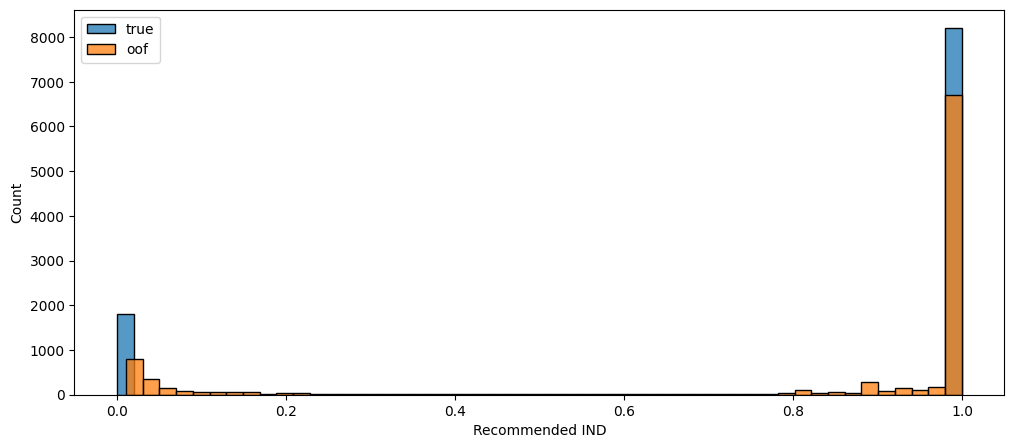

In [5]:
import seaborn as sns
from matplotlib import pyplot as plt

oof_df = pd.DataFrame({"oof": oof})
oof_df.to_csv(f"{cfg.data.results_dir}/oof.csv", index=False)

best_score = roc_auc_score(y_train, oof)
with open(f"{cfg.data.results_dir}/log.txt", "w") as log_file:
    log_file.write("====== CV Score ======\n")
    log_file.write(f"best_score: {best_score}\n")
    log_file.write("\n====== params ======\n")
    log_file.write(OmegaConf.to_yaml(cfg, resolve=True))

fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(y_train, bins=50)
sns.histplot(oof, bins=50)
plt.legend(["true", "oof"])
plt.show()
fig.savefig(f"{cfg.data.results_dir}/oof_hist.png")


### SUbmission

In [6]:
def tokenize(sample):
    return tokenizer(sample['prompt'], max_length=cfg.bert.params.max_length, truncation=True)

preds = []
for i in range(5):
    results_dir = f"{cfg.data.results_dir}/fold{i}/final"
    tokenizer = AutoTokenizer.from_pretrained(results_dir)
    model = AutoModelForSequenceClassification.from_pretrained(results_dir)

    ds_test = Dataset.from_pandas(test_df[['prompt']].copy())
    ds_test = ds_test.map(tokenize).remove_columns(['prompt'])

    test_args = TrainingArguments(
        output_dir=cfg.data.results_dir,
        per_device_eval_batch_size=cfg.bert.params.per_device_eval_batch_size,
        do_predict=True,
        dataloader_drop_last=False,
    )
    trainer = Trainer(
        model=model,
        args=test_args,
        data_collator=DataCollatorWithPadding(tokenizer),
        tokenizer=tokenizer,
    )
    predictions = torch.softmax(torch.tensor(trainer.predict(ds_test).predictions), dim=1).numpy()
    preds.append(predictions[:, 1])

pred = np.mean(preds, axis=0)

# 提出用ファイル作成
sub_df = pd.read_csv(cfg.data.sample_submission_path)
sub_df["target"] = pred
sub_df.to_csv(f"{cfg.data.results_dir}/{cfg.run_name}_submission.csv", index=False)
sub_df.head()


Map:   0%|          | 0/11155 [00:00<?, ? examples/s]

Map:   0%|          | 0/11155 [00:00<?, ? examples/s]

Map:   0%|          | 0/11155 [00:00<?, ? examples/s]

Map:   0%|          | 0/11155 [00:00<?, ? examples/s]

Map:   0%|          | 0/11155 [00:00<?, ? examples/s]

,target
0,0.999041
1,0.261607
2,0.998844
3,0.033628
4,0.998573
